# TP1 EDA UCDP GEDEvent 25.1


En este TP se muestra una visión general del dataset UCDP GEDEvent 25.1, de eventos de violencia organizada por actores armados, con resultado letal. Se pretende preparar estos datos para su uso en el entrenamiento de un modelo clasificador que pueda predecir el nivel de muertes estimado (best) agregado sobre una celda de 1,8° de latitud por 1,8° de longitud.


In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

In [14]:
GEDEvent= pd.read_csv("../datasets/GEDEvent.csv")

In [15]:
# Paso 1: Expandir eventos a muertes mensuales

filas = []
for _, evento in GEDEvent.iterrows():
    duracion = pd.date_range(evento['date_start'], evento['date_end'], freq='MS')
    if len(duracion) == 0:
        duracion = pd.date_range(evento['date_start'], periods=1, freq='MS')
    muertes_mensuales = evento['best'] / len(duracion)
    for d in duracion:
        filas.append({
            'año': d.year,
            'mes': d.month,
            'latitud': evento['latitude'],
            'longitud': evento['longitude'],
            'muertes': muertes_mensuales
        })

df = pd.DataFrame(filas)

In [16]:
# Paso 2: Calcular índices de la cuadrícula 100x200
filas_cuadricula, columnas_cuadricula = 100, 200
df['fila'] = np.floor((-df['latitud'] + 90) / 1.8).astype(int)
df['columna'] = np.floor((df['longitud'] + 180) / 1.8).astype(int)
df['fila'] = df['fila'].clip(0, filas_cuadricula - 1)
df['columna'] = df['columna'].clip(0, columnas_cuadricula - 1)

In [17]:
# Paso 3: Fechas únicas ordenadas
fechas = df[['año', 'mes']].drop_duplicates().sort_values(by=['año', 'mes']).to_records(index=False)

In [18]:
# Paso 4: Crear grillas por mes (muertes acumuladas)
grillas_muertes = []
for año, mes in fechas:
    datos_mes = df[(df['año'] == año) & (df['mes'] == mes)]
    cuadricula = np.zeros((filas_cuadricula, columnas_cuadricula))
    grupo = datos_mes.groupby(['fila', 'columna'])['muertes'].sum()
    for (f, c), valor in grupo.items():
        cuadricula[int(f), int(c)] = valor
    grillas_muertes.append(cuadricula)



In [19]:
# Paso 5: Clasificar las celdas en 4 niveles
def asignar_bin(cuadricula):
    niveles = np.full_like(cuadricula, 0)
    niveles[(cuadricula > 0) & (cuadricula <= 5)] = 1    # Bajo
    niveles[(cuadricula > 5) & (cuadricula <= 100)] = 2  # Medio
    niveles[cuadricula > 100] = 3                        # Alto
    return niveles

grillas_clasificadas = [asignar_bin(c) for c in grillas_muertes]

In [20]:
# Paso 6: Configurar animación
etiquetas = ['Seguro', 'Bajo', 'Medio', 'Alto']
colores = ['white', 'yellow', 'orange', 'red']
cmapa = plt.matplotlib.colors.ListedColormap(colores)
imagen_mapa = mpimg.imread('img/World_location_map_(equirectangular_180)2.png')
fig, ax = plt.subplots(figsize=(12, 6))

def actualizar(frame):
    ax.clear()
    cuadricula = grillas_clasificadas[frame]
    año, mes = fechas[frame]
    ax.imshow(imagen_mapa, extent=[0, columnas_cuadricula, filas_cuadricula, 0])
    ax.imshow(cuadricula, cmap=cmapa, vmin=0, vmax=3, alpha=0.6)

    ax.set_title(f"Muertes por conflicto armado: {año}-{mes:02d}")
    ax.axis('off')



    
plt.close(fig)

In [2]:
# PESADO

# import matplotlib
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# matplotlib.rcParams['animation.embed_limit'] = 200 * 1024 * 1024

# Paso 7: Animar
# ani = FuncAnimation(fig, actualizar, frames=len(fechas), interval=150)
# HTML(ani.to_jshtml())


In [22]:
for i, grid in enumerate(grillas_clasificadas):
    df = pd.DataFrame(grid)
    df.to_csv(f"../datasets/bin/grid_{i}.csv", index=False, header=False)

In [23]:

# Stack all grids into a 3D array: (frames, rows, cols)
stacked = np.stack(grillas_clasificadas, axis=0)

# Apply condition: 0 stays 0, anything >0 becomes 1
union_grid = (stacked > 0).any(axis=0).astype(int)
pd.DataFrame(union_grid).to_csv("../datasets/bin/union_grid.csv", index=False, header=False)
print(union_grid.shape)
print(union_grid)

(100, 200)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


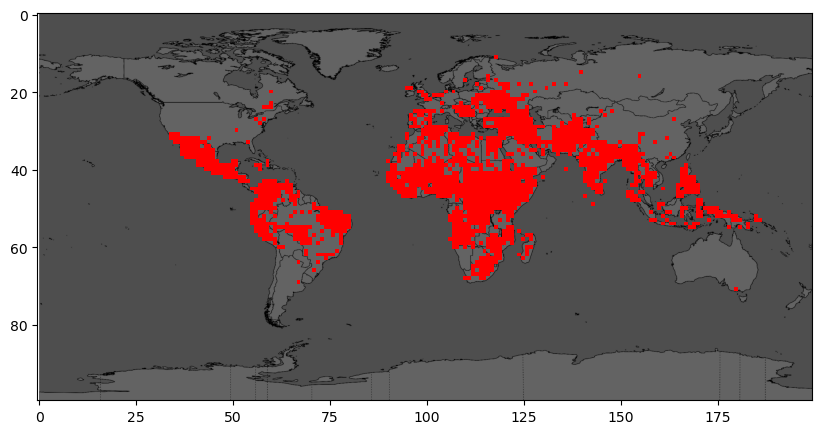

In [24]:

cmap = mcolors.ListedColormap(["none", "red"]) 
plt.figure(figsize=(10, 6))
mapa = mpimg.imread('img/World_location_map_(equirectangular_180).png')
plt.imshow(mapa, extent=[0, union_grid.shape[1], 0, union_grid.shape[0]], origin='lower')
plt.imshow(union_grid, cmap=cmap)
plt.show()
